## Just click run all and at the end cell, you will find a link generated to the app. Visit the link and interact with it.

### About the app: Crowd Estimation app where crowd is estimated from pictures (CNN based attention models run in the background)

In [1]:
# Install required packages
!pip install -q fastapi uvicorn python-multipart pillow pyngrok qrcode[pil]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.5/95.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00


In [2]:
# Check and create directory structure
import os
print("Current working directory:", os.getcwd())

# Create directories
!mkdir -p /kaggle/working/models /kaggle/working/static
!chmod 777 /kaggle/working/static  # Make it writable

# Copy model files
!cp -r /kaggle/input/sp-test1/models/*.py /kaggle/working/models/
!touch /kaggle/working/models/__init__.py

# Copy model weights
!cp /kaggle/input/man-model/model.pth /kaggle/working/

Current working directory: /kaggle/working


In [3]:
%%writefile /kaggle/working/main.py
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from fastapi.responses import FileResponse, JSONResponse
from fastapi.staticfiles import StaticFiles
import torch
import numpy as np
import cv2
from PIL import Image
import io
from torchvision import transforms
import logging
import math
import sys
import os
from typing import Dict, Any
import base64
from datetime import datetime

# Add the model directory to path
sys.path.append('/kaggle/working')
from models.vgg_c import vgg19_trans

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize FastAPI app
app = FastAPI(title="Crowd Management API")

# Add CORS middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Create static folder if it doesn't exist
os.makedirs('/kaggle/working/static', exist_ok=True)

# Mount static files directory
app.mount("/static", StaticFiles(directory="/kaggle/working/static"), name="static")

# Determine device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# Initialize model and load weights to the appropriate device
try:
    model = vgg19_trans()
    model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location=device))
    model.to(device)
    model.eval()
    logger.info("Model loaded successfully")
except Exception as e:
    logger.error(f"Failed to load model: {str(e)}")
    raise

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def process_image(image_bytes: bytes) -> tuple[torch.Tensor, np.ndarray]:
    """Process uploaded image for model input"""
    try:
        # Read image
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        original_size = image.size
        
        # Calculate new dimensions while maintaining aspect ratio
        min_size = 512
        max_size = 2048
        w, h = image.size
        
        scale = min_size / min(h, w)
        if h * scale > max_size or w * scale > max_size:
            scale = max_size / max(h, w)
        
        new_h = int(h * scale)
        new_w = int(w * scale)
        
        # Resize image
        image_resized = image.resize((new_w, new_h), Image.BICUBIC)
        
        # Convert to tensor
        img_tensor = transform(image_resized).unsqueeze(0)
        
        # Convert to numpy array for overlay
        original_np = np.array(image)
        
        return img_tensor, original_np
    except Exception as e:
        logger.error(f"Error processing image: {str(e)}")
        raise HTTPException(status_code=400, detail="Invalid image format")

def generate_heatmap(density_map: np.ndarray, original_image: np.ndarray) -> np.ndarray:
    """Generate heatmap overlay"""
    try:
        # Resize density map to match original image size
        density_map = cv2.resize(density_map, (original_image.shape[1], original_image.shape[0]))
        
        # Normalize density map
        density_map = (density_map - density_map.min()) / (density_map.max() - density_map.min() + 1e-8)
        
        # Create heatmap
        heatmap = cv2.applyColorMap((density_map * 255).astype(np.uint8), cv2.COLORMAP_JET)
        
        # Create overlay
        overlay = cv2.addWeighted(original_image, 0.6, heatmap, 0.4, 0)
        
        return overlay
    except Exception as e:
        logger.error(f"Error generating heatmap: {str(e)}")
        raise

def get_prediction(image_tensor: torch.Tensor, original_image: np.ndarray) -> Dict[str, Any]:
    """Get crowd count prediction and heatmap"""
    try:
        with torch.no_grad():
            # Move tensor to the correct device
            image_tensor = image_tensor.to(device)
            
            # Get density map prediction
            density_map = model(image_tensor)[0]
            
            # Calculate count
            count = density_map.sum().item()
            
            # Convert density map to numpy
            density_map_np = density_map.squeeze().cpu().numpy()
            
            # Generate heatmap overlay
            overlay = generate_heatmap(density_map_np, original_image)
            
            # Convert to base64 for direct embedding
            _, buffer = cv2.imencode('.jpg', cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            img_str = base64.b64encode(buffer).decode('utf-8')
            
            return {
                "count": round(count),
                "heatmap_base64": f"data:image/jpeg;base64,{img_str}",
                "status": "success"
            }
    except Exception as e:
        logger.error(f"Error during prediction: {str(e)}")
        raise HTTPException(status_code=500, detail="Prediction failed")

@app.get("/")
def read_root():
    """Root endpoint"""
    return {"message": "Welcome to the Crowd Management API"}

@app.get("/test")
def test_endpoint():
    """Simple test endpoint"""
    return {"status": "API is working", "timestamp": str(datetime.now())}

@app.post("/predict/")
async def predict(file: UploadFile = File(...)) -> Dict[str, Any]:
    """Predict crowd count from image"""
    if not file.content_type.startswith("image/"):
        raise HTTPException(status_code=400, detail="File must be an image")
    
    try:
        # Read image
        image_bytes = await file.read()
        
        # Process image
        image_tensor, original_image = process_image(image_bytes)
        
        # Get prediction and heatmap
        result = get_prediction(image_tensor, original_image)
        
        return result
    except Exception as e:
        logger.error(f"Error processing request: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

Writing /kaggle/working/main.py


In [4]:
%%writefile /kaggle/working/static/frontend.html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>CrowdSense</title>
    <link href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.0.0/css/all.min.css" rel="stylesheet">
    <style>
        :root {
            --primary-color: #2c3e50;
            --secondary-color: #3498db;
            --accent-color: #e74c3c;
            --success-color: #2ecc71;
            --warning-color: #f1c40f;
            --bg-color: #ecf0f1;
            --card-bg: #ffffff;
        }

        * {
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }

        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            background-color: var(--bg-color);
            color: var(--primary-color);
            line-height: 1.6;
        }

        .header {
            background-color: var(--primary-color);
            color: white;
            padding: 1rem 0;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }

        .header-content {
            max-width: 1200px;
            margin: 0 auto;
            padding: 0 20px;
            display: flex;
            align-items: center;
            justify-content: space-between;
        }

        .logo {
            display: flex;
            align-items: center;
            gap: 10px;
            font-size: 1.5rem;
            font-weight: bold;
        }

        .logo i {
            color: var(--secondary-color);
        }

        .container {
            max-width: 1200px;
            margin: 2rem auto;
            padding: 0 20px;
        }

        .main-content {
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 2rem;
            margin-top: 2rem;
        }

        .upload-section {
            background: var(--card-bg);
            padding: 2rem;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            text-align: center;
            transition: all 0.3s ease;
        }

        .dropzone {
            border: 2px dashed #ccc;
            padding: 2rem;
            border-radius: 8px;
            margin: 1rem 0;
            transition: all 0.3s ease;
            cursor: pointer;
        }

        .dropzone:hover, .dropzone.dragover {
            border-color: var(--secondary-color);
            background-color: rgba(52, 152, 219, 0.1);
        }

        .analysis-section {
            background: var(--card-bg);
            padding: 2rem;
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }

        .result-card {
            margin-top: 1rem;
            display: none;
        }

        .stats-grid {
            display: grid;
            grid-template-columns: repeat(2, 1fr);
            gap: 1rem;
            margin: 1rem 0;
        }

        .stat-card {
            background: var(--bg-color);
            padding: 1rem;
            border-radius: 8px;
            text-align: center;
        }

        .stat-value {
            font-size: 1.5rem;
            font-weight: bold;
            color: var(--secondary-color);
        }

        .density-indicator {
            display: flex;
            align-items: center;
            justify-content: space-between;
            margin: 1rem 0;
            padding: 1rem;
            background: var(--bg-color);
            border-radius: 8px;
        }

        .density-level {
            font-weight: bold;
        }

        .density-bar {
            flex-grow: 1;
            height: 10px;
            background: #ddd;
            margin: 0 1rem;
            border-radius: 5px;
            overflow: hidden;
        }

        .density-fill {
            height: 100%;
            width: 0%;
            transition: width 0.5s ease;
        }

        .image-display {
            width: 100%;
            border-radius: 8px;
            margin-top: 1rem;
            display: none;
        }

        .btn {
            background-color: var(--secondary-color);
            color: white;
            padding: 0.8rem 1.5rem;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 1rem;
            transition: all 0.3s ease;
        }

        .btn:hover {
            transform: translateY(-2px);
            box-shadow: 0 2px 8px rgba(0,0,0,0.2);
        }

        .loading {
            display: none;
            margin: 1rem 0;
        }

        .spinner {
            width: 40px;
            height: 40px;
            border: 4px solid #f3f3f3;
            border-top: 4px solid var(--secondary-color);
            border-radius: 50%;
            animation: spin 1s linear infinite;
            margin: 0 auto;
        }

        @keyframes spin {
            0% { transform: rotate(0deg); }
            100% { transform: rotate(360deg); }
        }

        .error-message {
            color: var(--accent-color);
            margin: 1rem 0;
            display: none;
        }

        .history-section {
            margin-top: 2rem;
            padding: 2rem;
            background: var(--card-bg);
            border-radius: 10px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }

        .history-grid {
            display: grid;
            grid-template-columns: repeat(auto-fill, minmax(250px, 1fr));
            gap: 1rem;
            margin-top: 1rem;
        }

        .history-card {
            background: var(--bg-color);
            padding: 1rem;
            border-radius: 8px;
            text-align: center;
        }

        .history-card img {
            width: 100%;
            height: 150px;
            object-fit: cover;
            border-radius: 4px;
            margin-bottom: 0.5rem;
        }

        @media (max-width: 768px) {
            .main-content {
                grid-template-columns: 1fr;
            }

            .stats-grid {
                grid-template-columns: 1fr;
            }
        }

        @media (max-width: 480px) {
            .density-indicator {
                flex-direction: column;
                align-items: flex-start;
            }
            
            .density-bar {
                width: 100%;
                margin: 10px 0;
            }
            
            .btn {
                width: 100%;
                margin-top: 10px;
            }
        }
    </style>
</head>
<body>
    <header class="header">
        <div class="header-content">
            <div class="logo">
                <i class="fas fa-users"></i>
                CrowdSense
            </div>
            <div class="header-actions">
                <button class="btn" onclick="clearHistory()">
                    <i class="fas fa-trash"></i> Clear History
                </button>
            </div>
        </div>
    </header>

    <div class="container">
        <div class="main-content">
            <div class="upload-section">
                <h2><i class="fas fa-cloud-upload-alt"></i> Upload Image</h2>
                <div class="dropzone" id="dropzone">
                    <input type="file" id="fileInput" accept="image/*" hidden>
                    <i class="fas fa-cloud-upload-alt" style="font-size: 3rem; color: #ccc;"></i>
                    <p>Drag and drop your image here or click to browse</p>
                </div>
                <button class="btn" onclick="document.getElementById('fileInput').click()">
                    <i class="fas fa-folder-open"></i> Select File
                </button>
                
                <div class="loading">
                    <div class="spinner"></div>
                    <p>Analyzing image...</p>
                </div>
                
                <div class="error-message"></div>
            </div>

            <div class="analysis-section">
                <h2><i class="fas fa-chart-bar"></i> Analysis Results</h2>
                <div class="result-card">
                    <div class="stats-grid">
                        <div class="stat-card">
                            <h3>Total Count</h3>
                            <div class="stat-value" id="crowdCount">0</div>
                        </div>
                        <div class="stat-card">
                            <h3>Density Level</h3>
                            <div class="stat-value" id="densityLevel">Low</div>
                        </div>
                    </div>

                    <div class="density-indicator">
                        <span class="density-level">Crowd Density:</span>
                        <div class="density-bar">
                            <div class="density-fill" id="densityBar"></div>
                        </div>
                        <span id="densityPercentage">0%</span>
                    </div>

                    <img id="heatmapImage" class="image-display" alt="Heatmap Overlay">
                </div>
            </div>
        </div>

        <div class="history-section">
            <h2><i class="fas fa-history"></i> Analysis History</h2>
            <div class="history-grid" id="historyGrid"></div>
        </div>
    </div>

    <script>
        // Set the API base URL (will be replaced with ngrok URL)
        const API_BASE_URL = "NGROK_URL";
        
        // DOM Elements
        const dropzone = document.getElementById('dropzone');
        const fileInput = document.getElementById('fileInput');
        const loadingIndicator = document.querySelector('.loading');
        const resultCard = document.querySelector('.result-card');
        const crowdCount = document.getElementById('crowdCount');
        const densityLevel = document.getElementById('densityLevel');
        const densityBar = document.getElementById('densityBar');
        const densityPercentage = document.getElementById('densityPercentage');
        const heatmapImage = document.getElementById('heatmapImage');
        const errorMessage = document.querySelector('.error-message');
        const historyGrid = document.getElementById('historyGrid');

        // Drag and drop handlers
        ['dragenter', 'dragover', 'dragleave', 'drop'].forEach(eventName => {
            dropzone.addEventListener(eventName, preventDefaults, false);
        });

        function preventDefaults(e) {
            e.preventDefault();
            e.stopPropagation();
        }

        ['dragenter', 'dragover'].forEach(eventName => {
            dropzone.addEventListener(eventName, highlight, false);
        });

        ['dragleave', 'drop'].forEach(eventName => {
            dropzone.addEventListener(eventName, unhighlight, false);
        });

        function highlight(e) {
            dropzone.classList.add('dragover');
        }

        function unhighlight(e) {
            dropzone.classList.remove('dragover');
        }

        dropzone.addEventListener('drop', handleDrop, false);

        function handleDrop(e) {
            const dt = e.dataTransfer;
            const files = dt.files;
            handleFiles(files);
        }

        // File input handler
        fileInput.addEventListener('change', function(e) {
            handleFiles(this.files);
        });

        function handleFiles(files) {
            if (files.length > 0) {
                processImage(files[0]);
            }
        }

        // Calculate density level
        function calculateDensityLevel(count) {
            if (count < 50) return { level: 'Low', percentage: 20, color: '#2ecc71' };
            if (count < 100) return { level: 'Moderate', percentage: 40, color: '#f1c40f' };
            if (count < 200) return { level: 'High', percentage: 60, color: '#e67e22' };
            if (count < 400) return { level: 'Very High', percentage: 80, color: '#e74c3c' };
            return { level: 'Extreme', percentage: 100, color: '#c0392b' };
        }

        // Process image
        async function processImage(file) {
            // Reset UI
            errorMessage.style.display = 'none';
            resultCard.style.display = 'none';
            loadingIndicator.style.display = 'block';
            heatmapImage.style.display = 'none';

            try {
                const formData = new FormData();
                formData.append('file', file);

                const response = await fetch(`${API_BASE_URL}/predict/`, {
                    method: 'POST',
                    body: formData
                });

                if (!response.ok) {
                    throw new Error('Prediction failed');
                }

                const result = await response.json();
                
                // Debug
                console.log("API response:", result);

                // Update UI with results
                const density = calculateDensityLevel(result.count);
                
                crowdCount.textContent = result.count;
                densityLevel.textContent = density.level;
                densityBar.style.width = `${density.percentage}%`;
                densityBar.style.backgroundColor = density.color;
                densityPercentage.textContent = `${density.percentage}%`;
                
                // Use the base64 image data directly
                heatmapImage.src = result.heatmap_base64;
                heatmapImage.style.display = 'block';
                resultCard.style.display = 'block';

                // Add to history with base64 image
                addToHistory({
                    count: result.count,
                    densityLevel: density.level,
                    heatmapBase64: result.heatmap_base64,
                    timestamp: new Date().toLocaleString()
                });

            } catch (error) {
                errorMessage.textContent = 'Error processing image. Please try again.';
                errorMessage.style.display = 'block';
                console.error('Error:', error);
            } finally {
                loadingIndicator.style.display = 'none';
            }
        }

        // History management
        function addToHistory(analysis) {
            let history = getHistory();
            history.unshift(analysis);
            history = history.slice(0, 6); // Keep only last 6 analyses
            localStorage.setItem('crowdAnalysisHistory', JSON.stringify(history));
            updateHistoryDisplay();
        }

        function getHistory() {
            const history = localStorage.getItem('crowdAnalysisHistory');
            return history ? JSON.parse(history) : [];
        }

        function clearHistory() {
            localStorage.removeItem('crowdAnalysisHistory');
            updateHistoryDisplay();
        }

        function updateHistoryDisplay() {
            const history = getHistory();
            historyGrid.innerHTML = history.map(item => `
                <div class="history-card">
                    <img src="${item.heatmapBase64 || `${API_BASE_URL}${item.heatmapUrl}`}" alt="Historical heatmap">
                    <div class="history-stats">
                        <p><strong>Count:</strong> ${item.count}</p>
                        <p><strong>Density:</strong> ${item.densityLevel}</p>
                        <p><small>${item.timestamp}</small></p>
                    </div>
                </div>
            `).join('');

            if (history.length === 0) {
                historyGrid.innerHTML = `
                    <div style="grid-column: 1/-1; text-align: center; padding: 2rem;">
                        <i class="fas fa-history" style="font-size: 2rem; color: #ccc;"></i>
                        <p>No analysis history available</p>
                    </div>
                `;
            }
        }

        // Initialize history display on page load
        document.addEventListener('DOMContentLoaded', () => {
            updateHistoryDisplay();
        });
    </script>
</body>
</html>

Writing /kaggle/working/static/frontend.html


Closing any existing ngrok tunnels...
Starting FastAPI server...                                                                          
Waiting for server to be ready...
Waiting for server to start... (1/15)
Waiting for server to start... (2/15)
Waiting for server to start... (3/15)
Waiting for server to start... (4/15)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:01<00:00, 364MB/s] 

Waiting for server to start... (5/15)



/kaggle/working/main.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location=device))
INFO:     Star

INFO:     127.0.0.1:47476 - "GET / HTTP/1.1" 200 OK
✅ Server is ready!
Starting ngrok tunnel...

✅ Server is running!
📱 Access your CrowdSense application at this URL:

    https://31a1-35-229-197-217.ngrok-free.app/static/frontend.html

Generating QR code for mobile access...
📱 Scan this QR code to open the application on your mobile device:


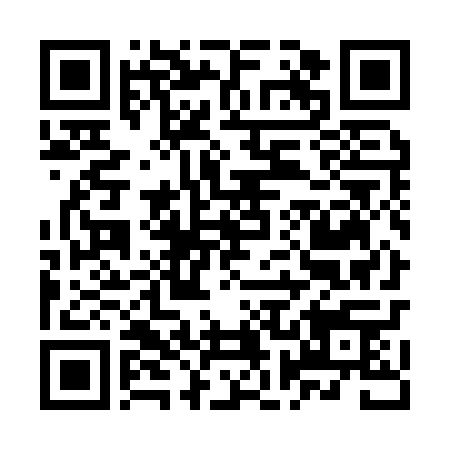


Keep this notebook running to maintain the connection.


In [5]:
# Import required libraries
import uvicorn
import nest_asyncio
import threading
import time
import requests
from requests.exceptions import ConnectionError
from pyngrok import ngrok, conf
import qrcode
from IPython.display import Image as IPImage, HTML, clear_output

# Apply nest_asyncio to allow running async code in Jupyter
nest_asyncio.apply()

# Configure ngrok with your auth token
ngrok_config = conf.PyngrokConfig(auth_token="2vV7rat6O8kDcoTFhOJHVWKp4Zk_37maUmv3dsfVD31vwToL1")
conf.set_default(ngrok_config)

# Close any existing tunnels
print("Closing any existing ngrok tunnels...")
tunnels = ngrok.get_tunnels()
for tunnel in tunnels:
    print(f"Disconnecting tunnel: {tunnel.public_url}")
    ngrok.disconnect(tunnel.public_url)

# Define the port for your server
port = 8000

# Function to run the server
def run_server():
    uvicorn.run("main:app", host="127.0.0.1", port=port, app_dir="/kaggle/working")

# Start the server in a separate thread
print("Starting FastAPI server...")
server_thread = threading.Thread(target=run_server)
server_thread.daemon = True
server_thread.start()

# Wait for server to be ready with status checks
print("Waiting for server to be ready...")
max_retries = 15
for i in range(max_retries):
    try:
        response = requests.get(f"http://localhost:{port}")
        if response.status_code == 200:
            print("✅ Server is ready!")
            break
    except ConnectionError:
        print(f"Waiting for server to start... ({i+1}/{max_retries})")
        time.sleep(2)
else:
    print("⚠️  Warning: Server might not be fully ready, but continuing anyway...")

# Now create the ngrok tunnel
print("Starting ngrok tunnel...")
public_url = ngrok.connect(port).public_url
frontend_url = f"{public_url}/static/frontend.html"

# Update the frontend with the correct URL
with open('/kaggle/working/static/frontend.html', 'r') as f:
    content = f.read()
    
content = content.replace('NGROK_URL', public_url)

with open('/kaggle/working/static/frontend.html', 'w') as f:
    f.write(content)

print(f"\n✅ Server is running!")
print(f"📱 Access your CrowdSense application at this URL:")
print(f"\n    {frontend_url}\n")

# Generate QR code for mobile access
print("Generating QR code for mobile access...")
img = qrcode.make(frontend_url)
img_path = '/kaggle/working/qrcode.png'
img.save(img_path)

print("📱 Scan this QR code to open the application on your mobile device:")
display(IPImage(filename=img_path, width=300))

# Create a clickable link
display(HTML(f'<a href="{frontend_url}" target="_blank" style="font-size:16px; background-color:#3498db; color:white; padding:10px 15px; border-radius:5px; text-decoration:none;">Open CrowdSense Application</a>'))

print("\nKeep this notebook running to maintain the connection.")

In [ ]:
# Keep the Kaggle notebook running and the ngrok tunnel alive
from IPython.display import clear_output
import time

# Display a status message
print(f"✅ Server is running at {frontend_url}")
print("Keep this notebook running to maintain the connection.")
print("The URL will remain active as long as this notebook is running.")

# Add a simple animation to show the notebook is still running
try:
    i = 0
    while True:
        clear_output(wait=True)
        print(f"✅ Server is running at {frontend_url}")
        print(f"Keep this notebook running to maintain the connection.")
        print(f"Time elapsed: {i} seconds")
        print(f"\nAccess app at: {frontend_url}")
        print("\nPress Ctrl+C to stop the server.")
        i += 10
        time.sleep(10)
except KeyboardInterrupt:
    print("Server stopped.")

✅ Server is running at https://31a1-35-229-197-217.ngrok-free.app/static/frontend.html
Keep this notebook running to maintain the connection.
Time elapsed: 120 seconds

Access app at: https://31a1-35-229-197-217.ngrok-free.app/static/frontend.html

Press Ctrl+C to stop the server.
